# Clean the text

In [1]:
from __future__ import division

import re
import string
import cPickle
import unicodedata
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from gensim.models import KeyedVectors

Read in the pickled text and put into a dataframe.

In [2]:
fin_name = './questions.pkl'

with open(fin_name, 'r') as f_in:
    text = cPickle.load(f_in)

df = pd.DataFrame()
df['text'] = text
df.head()

,text
0,"To ask Mr Chancellor of the Exchequer, whether..."
1,"To ask Mr Chancellor of the Exchequer, how man..."
2,To ask Her Majesty's Government whether an Eng...
3,"To ask Mr Chancellor of the Exchequer, how man..."
4,"To ask Mr Chancellor of the Exchequer, when he..."


Define a list of project specific stopwords.

In [3]:
my_stopwords = ['mr', 'ask', 'chancellor', 'exchequer']

Define a function to clean and tokenise the results.

In [4]:
def tokeniser(text):
    
    # Remove any whitespace at the start and end of the string
    # and remove any stray tabs and newline characters
    text = text.strip()
    
    # Remove any weird unicode characters
    if isinstance(text, unicode):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
        
    # Convert hyphens and slashes to spaces
    text = re.sub(r'[-/]+',' ',text)
    
    # Remove remaining punctuation
    text = text.translate(None, string.punctuation)
    
    # Convert the text to lowercase and use nltk tokeniser
    tokens = word_tokenize(text.lower())
    
    # Define a list of stopwords apart from the word 'not'
    stops = set(stopwords.words('english') + my_stopwords) - set(('not'))

    # Define stemmer
    stemmer = SnowballStemmer('english')

    return [stemmer.stem(i) for i in tokens if i not in stops]


Apply this function.

In [5]:
df['tokens'] = df['text'].apply(tokeniser)
df.head()

,text,tokens
0,"To ask Mr Chancellor of the Exchequer, whether...","[whether, rate, corpor, tax, paid, privat, sec..."
1,"To ask Mr Chancellor of the Exchequer, how man...","[mani, credit, union, subject, intervent, fina..."
2,To ask Her Majesty's Government whether an Eng...,"[majesti, govern, whether, english, coupl, mar..."
3,"To ask Mr Chancellor of the Exchequer, how man...","[mani, proport, depart, answer, written, parli..."
4,"To ask Mr Chancellor of the Exchequer, when he...","[plan, publish, data, except, two, child, tax,..."


Word clouds are a good check that no stop words have been missed.

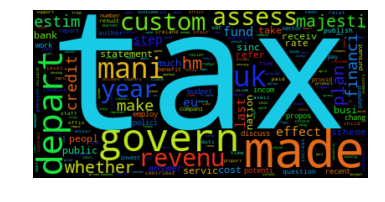

In [6]:
# Combined the tokens back into whole strings
cleaned_strings = df['tokens'].apply(lambda x: ' '.join(x)).tolist()

# Join the strings together
combined_text = ' '.join(cleaned_strings)

# Display a word cloud
wc = WordCloud().generate( combined_text )
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Create document vectors

https://groups.google.com/forum/#!topic/word2vec-toolkit/TI-TQC-b53w
https://github.com/eyaler/word2vec-slim

In [7]:
import gensim

f_word2vec = './GoogleNews-vectors-negative300-SLIM.bin'
# Load Google's pre-trained Word2Vec model.
model = KeyedVectors.load_word2vec_format(f_word2vec, binary=True) 

In [8]:
def word2vec_preprocess(text):
    
    # Remove any whitespace at the start and end of the string
    # and remove any stray tabs and newline characters
    text = text.strip()
    
    # Remove any weird unicode characters
    if isinstance(text, unicode):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
        
    # Convert hyphens and slashes to spaces
    text = re.sub(r'[-/]+',' ',text)
    
    # Remove remaining punctuation
    text = text.translate(None, string.punctuation)
    
    # Convert numbers to text
    text = re.sub(r'0\s*', 'zero ', text)
    text = re.sub(r'1\s*', 'one ', text)
    text = re.sub(r'2\s*', 'two ', text)
    text = re.sub(r'3\s*', 'three ', text)
    text = re.sub(r'4\s*', 'four ', text)
    text = re.sub(r'5\s*', 'five ', text)
    text = re.sub(r'6\s*', 'six ', text)
    text = re.sub(r'7\s*', 'seven ', text)
    text = re.sub(r'8\s*', 'eight ', text)
    text = re.sub(r'9\s*', 'nine ', text)
    
    # Convert the text to lowercase and use nltk tokeniser
    tokens = word_tokenize(text.lower())
    
    # Define a list of stopwords apart from the word 'not'
    stops = set(stopwords.words('english') + my_stopwords) - set(('not'))

    return [i for i in tokens if i not in stops]


def calc_vector(text, model, idf):
    vector = np.zeros(300)
    for word in text:
        if (word in idf) and (word in model):
            vector += idf[word]*model[word]
                
    return vector
            
def generate_doc_vecs(df_corpus, model):
    
    df_tokens = df_corpus.apply(word2vec_preprocess)
    
    tfidf = TfidfVectorizer(
            tokenizer = lambda x: x, 
            preprocessor = None, 
            lowercase = False, 
            ngram_range = [1,1]
        )
    
    tfidf.fit(df_tokens)
    idf = dict( zip(tfidf.get_feature_names(), tfidf.idf_) )
    
    df_vectors = df_tokens.apply(lambda x: calc_vector(x, model, idf))
    
    return df_vectors

In [9]:
df['doc_vectors'] = generate_doc_vecs(df['text'], model)
df.head()

,text,tokens,doc_vectors
0,"To ask Mr Chancellor of the Exchequer, whether...","[whether, rate, corpor, tax, paid, privat, sec...","[-0.826813070104, 0.617163865827, 1.3689254140..."
1,"To ask Mr Chancellor of the Exchequer, how man...","[mani, credit, union, subject, intervent, fina...","[0.48444006592, 0.077450694982, -1.10990267806..."
2,To ask Her Majesty's Government whether an Eng...,"[majesti, govern, whether, english, coupl, mar...","[0.925785131752, -1.39836918376, -2.0231705308..."
3,"To ask Mr Chancellor of the Exchequer, how man...","[mani, proport, depart, answer, written, parli...","[-0.932871524245, -1.18145282334, 1.7405875200..."
4,"To ask Mr Chancellor of the Exchequer, when he...","[plan, publish, data, except, two, child, tax,...","[-0.358848564327, -0.0916081666946, 0.15943405..."


## Save the dataframe.

In [10]:
fout_name = "./tokenised.pkl"
df.to_pickle(fout_name)